## Use of VFA methods
The goal of this notebook is to show if it is possible to use VFA methods in the Slimevolley gym environment.

In [2]:
from os.path import join
from slime import Slime
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
import gym
import slimevolleygym
from algorithms import *


# Define our input folders and output files
DATADIR = join('..', 'data')
MODELDIR = join('..', 'models')
SAMPLES_FILE = 'sampled_states.csv'

TRAIN_FLAG = False

In [3]:
if TRAIN_FLAG:
    slime = Slime('BSLN')
    random_ss = slime.sample_states(10_000, 'RANDOM')
    bsln_ss = slime.sample_states(1_000_000, 'MODEL')

    head = 'x_agent,y_agent,xdot_agent,ydot_agent,' \
        'x_ball,y_ball,xdot_ball,ydot_ball,' \
        'x_opponent,y_opponent,xdot_opponent,ydot_opponent'
        
    def save_ss_file(ss, name):
        np.savetxt(fname=join(DATADIR, name),
                X=ss,
                fmt='%.5f',
                delimiter=',',
                header=head,
                comments='')
        
    save_ss_file(random_ss, "ss_random.csv")
    save_ss_file(bsln_ss, "ss_bsln.csv")

We read the file `sampled_states.csv`. This is a database which contains 1M observations of the simulation of the agent playing with the opponent, both using the baseline policy (based on neural net)

In [4]:
ss_random = pd.read_csv(join(DATADIR, 'ss_random.csv'))
ss_bsln = pd.read_csv(join(DATADIR, 'ss_bsln.csv'))

We create a normalized dataframe `ss_norm`.

In [5]:
scaler = MinMaxScaler()
ss_random_norm = scaler.fit_transform(ss_random)
ss_bsln_norm = scaler.fit_transform(ss_bsln)
        

We create 3 `MiniBatchKMeans` estimators with 10K, 25K and 50K clusters and a batch size of 2048 and fit it with our normalized sampled states dataframe. The purpose of this is to reduce the information of our sampled states in a number clusters, which will be the centroids of the RBF used in the next cells.

In [6]:
if TRAIN_FLAG:
    mbkm_model_10 = MiniBatchKMeans(n_clusters=10_000, random_state=0, batch_size=2048, verbose=True)
    mbkm_model_10.fit(ss_bsln_norm)      # 6min

In [7]:
if TRAIN_FLAG:
    mbkm_model_25 = MiniBatchKMeans(n_clusters=25_000, random_state=0, batch_size=2048, verbose=True)
    mbkm_model_25.fit(ss_bsln_norm)      # 21min

In [8]:
if TRAIN_FLAG:
    mbkm_model_50 = MiniBatchKMeans(n_clusters=50_000, random_state=0, batch_size=2048, verbose=True)
    mbkm_model_50.fit(ss_bsln_norm)

We save the `cluster_centers_` from our `mbkm_model`in a file called `centroids_10K.csv`. This step is done so that we do not need to execute the clustering algorithm every time we want to use the centroids.

In [9]:
if TRAIN_FLAG:
    def save_centroids_file(model, name):
        head = 'x_agent,y_agent,xdot_agent,ydot_agent,' \
            'x_ball,y_ball,xdot_ball,ydot_ball,' \
            'x_opponent,y_opponent,xdot_opponent,ydot_opponent'        
        np.savetxt(fname=join(DATADIR, name),
            X=model.cluster_centers_,
            fmt='%.5f',
            delimiter=',',
            header=head,
            comments='')
        
    save_centroids_file(mbkm_model_10, "c_10.csv")
    save_centroids_file(mbkm_model_25, "c_25.csv")
    save_centroids_file(mbkm_model_50, "c_50.csv")

We save the information of the centroids from our files in a dataframe called `centroids_XX`. The shape of this dataframe will be 10K, 25K or 50K rows (depending on the number of clusters selected in our algorithm) by 12 columns (number of dimensions of the states of our environment).

In [49]:
centroids_10_df = pd.read_csv(join(DATADIR, "c_10.csv"))
centroids_25_df = pd.read_csv(join(DATADIR, "c_25.csv"))
centroids_50_df = pd.read_csv(join(DATADIR, "c_50.csv"))

In [50]:
ss_random_norm_df = pd.DataFrame(ss_random_norm)

In [51]:
centroids_10_df.iloc[8_000:, :] = ss_random_norm_df.sample(frac=0.2, random_state=0)
centroids_25_df.iloc[20_000:, :] = ss_random_norm_df.sample(frac=0.5, random_state=0)
centroids_50_df.iloc[40_000:, :] = ss_random_norm_df.sample(frac=1, random_state=0)

We create the definition of the function for the feature vector, which is encapsulated in a Featurizer class.

In [52]:
# Example for normalized state [0]
slime_env = gym.make('SlimeVolley-v0')
featurizer_10 = Featurizer(slime_env.observation_space, np.array(centroids_10_df))
x_10 = featurizer_10.feature_vector(ss_bsln_norm[0, :])
featurizer_25 = Featurizer(slime_env.observation_space, np.array(centroids_25_df))
x_25 = featurizer_25.feature_vector(ss_bsln_norm[0, :])
featurizer_50 = Featurizer(slime_env.observation_space, np.array(centroids_50_df))
x_50 = featurizer_50.feature_vector(ss_bsln_norm[0, :])

In [53]:
slime_env = gym.make('SlimeVolley-v0')

### 10K centroids

In [54]:
q = ValueFunction(featurizer_10, slime_env.action_space.n)
slime_q, slime_history, slime_history_average = semi_gradient_sarsa(slime_env, q, 1000) # alpha and epsilon values by defaultº

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.898989898989899
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.9045226130653266
episodio 300: alfa = 0.1, epsilon = 0.1, retorno medio = -4.866220735785953
episodio 400: alfa = 0.1, epsilon = 0.1, retorno medio = -4.889724310776942
episodio 500: alfa = 0.1, epsilon = 0.1, retorno medio = -4.891783567134269
episodio 600: alfa = 0.1, epsilon = 0.1, retorno medio = -4.893155258764608
episodio 700: alfa = 0.1, epsilon = 0.1, retorno medio = -4.884120171673819
episodio 800: alfa = 0.1, epsilon = 0.1, retorno medio = -4.888610763454318
episodio 900: alfa = 0.1, epsilon = 0.1, retorno medio = -4.886540600667408
episodio 1000: alfa = 0.1, epsilon = 0.1, retorno medio = -4.888888888888889


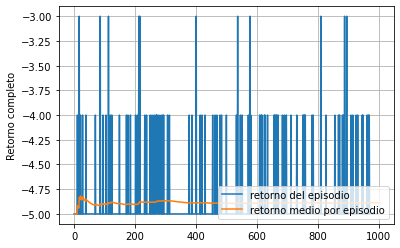

In [55]:
plot_history(slime_history, slime_history_average)

In [56]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.858585858585859
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.889447236180905
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.879598662207358
episodio 400: alfa = 0.05, epsilon = 0.1, retorno medio = -4.879699248120301
episodio 500: alfa = 0.05, epsilon = 0.1, retorno medio = -4.887775551102204
episodio 600: alfa = 0.05, epsilon = 0.1, retorno medio = -4.888146911519199
episodio 700: alfa = 0.05, epsilon = 0.1, retorno medio = -4.888412017167382
episodio 800: alfa = 0.05, epsilon = 0.1, retorno medio = -4.891113892365457
episodio 900: alfa = 0.05, epsilon = 0.1, retorno medio = -4.890989988876529
episodio 1000: alfa = 0.05, epsilon = 0.1, retorno medio = -4.891891891891892


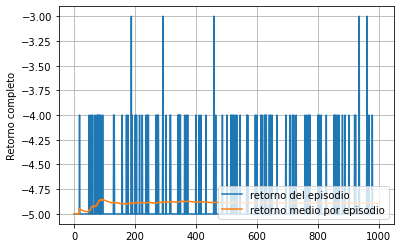

In [57]:
plot_history(slime_history, slime_history_average)

### 25K centroids

In [58]:
q = ValueFunction(featurizer_25, slime_env.action_space.n)
slime_q, slime_history, slime_history_average = semi_gradient_sarsa(slime_env, q, 1000) # alpha and epsilon values by defaultº

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.818181818181818
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.839195979899498
episodio 300: alfa = 0.1, epsilon = 0.1, retorno medio = -4.852842809364549
episodio 400: alfa = 0.1, epsilon = 0.1, retorno medio = -4.849624060150376
episodio 500: alfa = 0.1, epsilon = 0.1, retorno medio = -4.847695390781563
episodio 600: alfa = 0.1, epsilon = 0.1, retorno medio = -4.853088480801335
episodio 700: alfa = 0.1, epsilon = 0.1, retorno medio = -4.849785407725322
episodio 800: alfa = 0.1, epsilon = 0.1, retorno medio = -4.853566958698373
episodio 900: alfa = 0.1, epsilon = 0.1, retorno medio = -4.85650723025584
episodio 1000: alfa = 0.1, epsilon = 0.1, retorno medio = -4.85985985985986


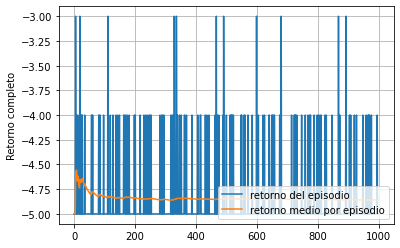

In [59]:
plot_history(slime_history, slime_history_average)

In [60]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.848484848484849
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.8793969849246235
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.872909698996655
episodio 400: alfa = 0.05, epsilon = 0.1, retorno medio = -4.867167919799499
episodio 500: alfa = 0.05, epsilon = 0.1, retorno medio = -4.867735470941883
episodio 600: alfa = 0.05, epsilon = 0.1, retorno medio = -4.873121869782971
episodio 700: alfa = 0.05, epsilon = 0.1, retorno medio = -4.876967095851216
episodio 800: alfa = 0.05, epsilon = 0.1, retorno medio = -4.878598247809762
episodio 900: alfa = 0.05, epsilon = 0.1, retorno medio = -4.878754171301446
episodio 1000: alfa = 0.05, epsilon = 0.1, retorno medio = -4.880880880880881


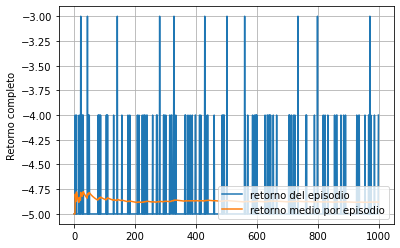

In [61]:
plot_history(slime_history, slime_history_average)

### 50K centroids

In [62]:
q_50 = ValueFunction(featurizer_50, slime_env.action_space.n)
slime_q_50, slime_history_50, slime_history_average_50 = semi_gradient_sarsa(slime_env, q_50, 1000) # alpha and epsilon values by defaultº

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.888888888888889
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.899497487437186
episodio 300: alfa = 0.1, epsilon = 0.1, retorno medio = -4.889632107023411
episodio 400: alfa = 0.1, epsilon = 0.1, retorno medio = -4.889724310776942
episodio 500: alfa = 0.1, epsilon = 0.1, retorno medio = -4.895791583166333
episodio 600: alfa = 0.1, epsilon = 0.1, retorno medio = -4.888146911519199
episodio 700: alfa = 0.1, epsilon = 0.1, retorno medio = -4.886981402002861
episodio 800: alfa = 0.1, epsilon = 0.1, retorno medio = -4.88360450563204
episodio 900: alfa = 0.1, epsilon = 0.1, retorno medio = -4.878754171301446
episodio 1000: alfa = 0.1, epsilon = 0.1, retorno medio = -4.877877877877878


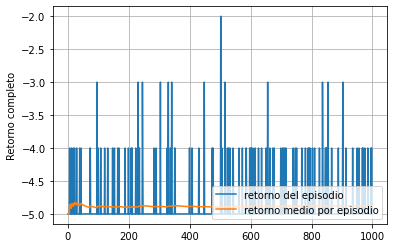

In [63]:
plot_history(slime_history_50, slime_history_average_50)

In [64]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.848484848484849
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.864321608040201
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.8561872909699


KeyboardInterrupt: 

In [ ]:
plot_history(slime_history, slime_history_average)